In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy
from numba.typed import Dict
from numba.core import types
import networkx as nx

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control import cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/3n")
dir = os.path.join(pickledir, "beat_osc")

print(dir)

def plotspectrum(data, fmax=1., filename=None, vlines=None):

    ps_comp = None

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        if ps_comp is None:
            ps_comp = ps_plot
        else:
            ps_comp += ps_plot

        plt.plot(fr, ps_plot)

    if vlines is not None:
        plt.vlines(vlines, 0, 1, color="gray", linestyle=":")

    plt.xlim(0,fmax)
    plt.ylim(0,1.3*np.amax(ps_plot))
    #plt.ylim(0,0.5)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_comp == max(ps_comp[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def draw_nwgraph(cmat):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.show()

options = {
'node_color': 'lightgray',
'node_size': 1000,
'width': 2,
'arrowstyle': '-|>',
'arrowsize': 20,
'font_size' : 20,
'font_weight' : 'bold',
}

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/3n/beat_osc


In [3]:
N = 3

cmat = np.array( [[0, 6, 2], [5, 0, 0], [13, 6, 0]] )
dmat = np.array( [[0, 6, 2], [5, 0, 0], [13, 6, 0]] )

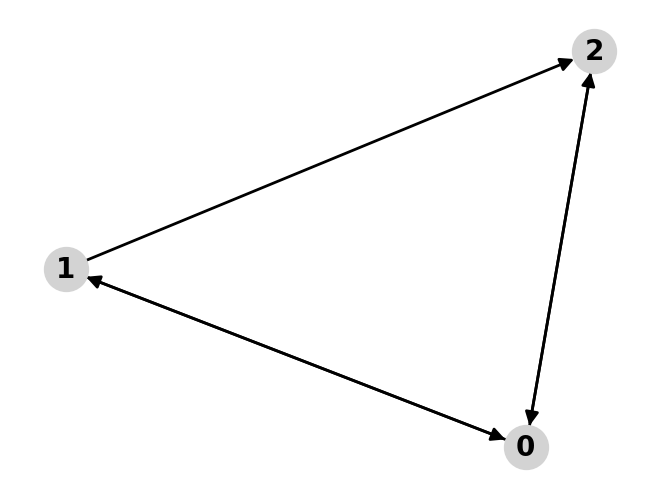

[[ 0  6  2]
 [ 5  0  0]
 [13  6  0]]
[[ 0  6  2]
 [ 5  0  0]
 [13  6  0]]


In [4]:
draw_nwgraph(cmat)

print(cmat)
print(dmat)

In [5]:
coupling_array = np.array( [0.2, 0.4, 0.6] )

eext = np.arange(-1., 3., 0.2)
iext = np.arange(-1., 3., 0.2)

eext = [1.8]
iext = [0.8]

----------------------------------------------------------- 0
1.8 0.8


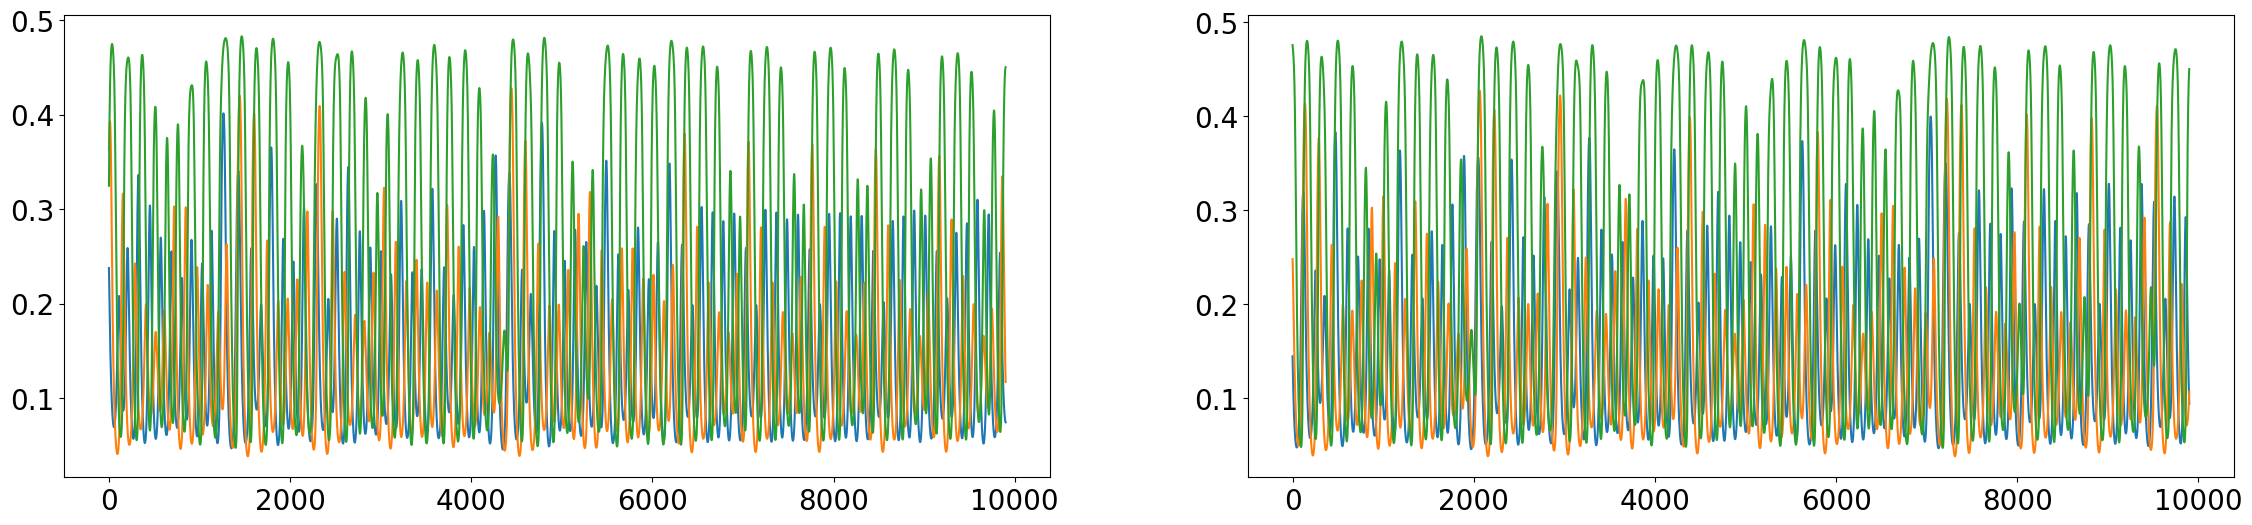

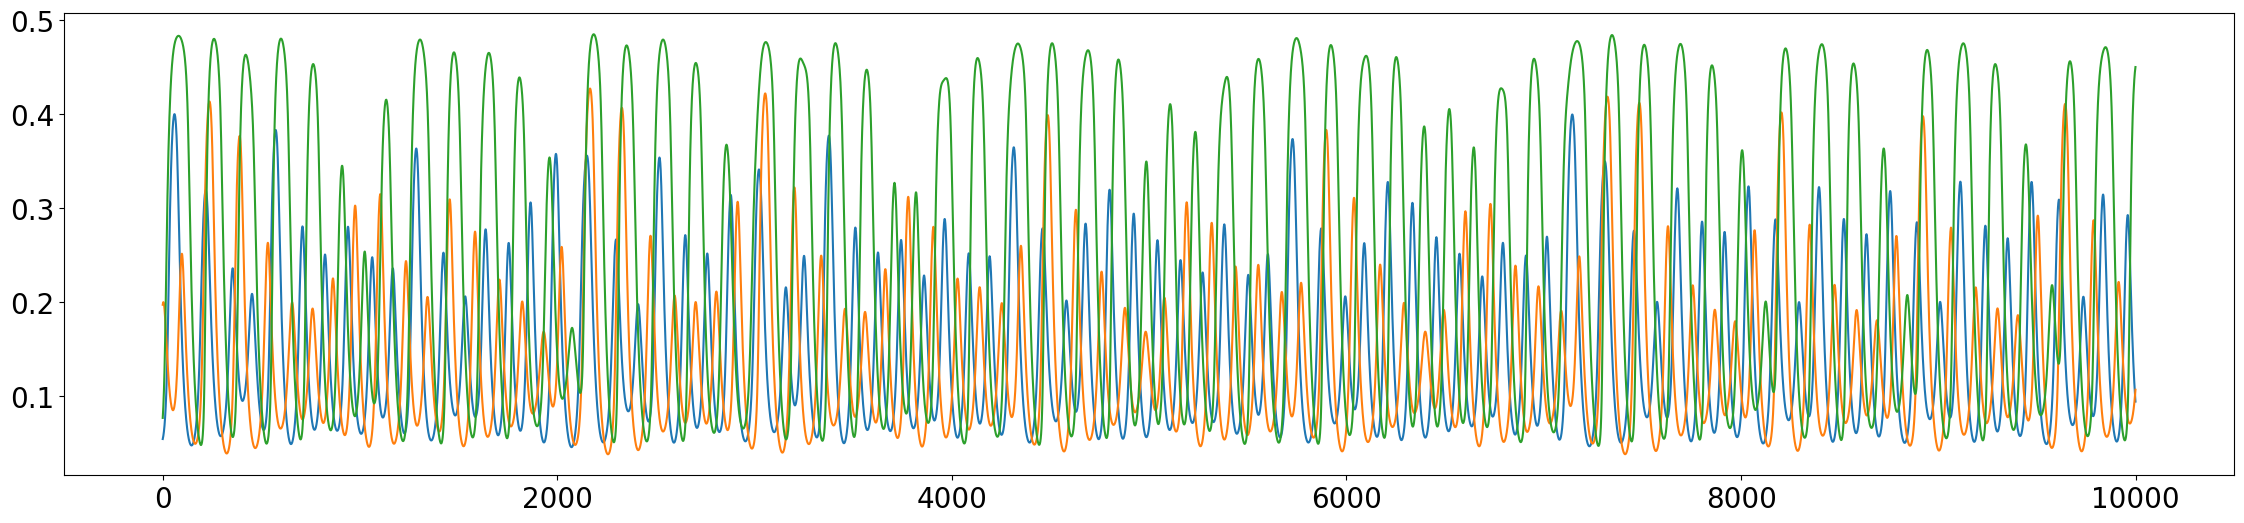

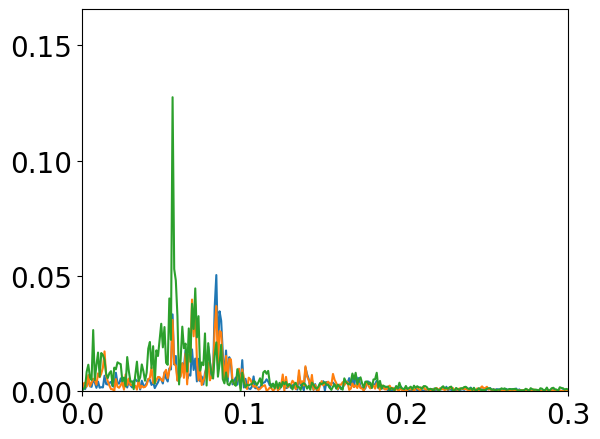

freq of max =  [0.0560112]
period of max =  [17.85357143]
----------------------------------------------------------- 1
----------------------------------------------------------- 2


In [6]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [0]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.1
            model.params.dt = dt

            dur = 4000.
            measure_dur = 30.
            i00, i01 = 0, 100
            i10, i11 = 20000, 20100

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            test_input[:,i00:i01] = 6.
            test_input[:,i10:i11] = -6.
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_
            model.params.exc_ext = test_input

            model.run()
            add_ind = 10000

            if np.var(model.exc[0,i01+add_ind:i10]) < 1e-6 and np.var(model.exc[0,i11+add_ind:]) < 1e-6:
                continue

            

            fig, ax = plt.subplots(1,2, figsize=(28,6))
            ax[0].plot(model.exc[0,i01+add_ind:i10])
            ax[0].plot(model.exc[1,i01+add_ind:i10])
            ax[0].plot(model.exc[2,i01+add_ind:i10])
            ax[1].plot(model.exc[0,i11+add_ind:])
            ax[1].plot(model.exc[1,i11+add_ind:])
            ax[1].plot(model.exc[2,i11+add_ind:])
            plt.show()

            if True:

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                ax.plot(model.exc[0,-add_ind:])
                ax.plot(model.exc[1,-add_ind:])
                ax.plot(model.exc[2,-add_ind:])
                plt.show()

                indstate = 20000

                state = np.zeros((3,2, indstate))
                state[0,0,:] = model.exc[0,-indstate:]
                state[1,0,:] = model.exc[1,-indstate:]
                state[2,0,:] = model.exc[2,-indstate:]
                state[0,1,:] = model.inh[0,-indstate:]
                state[1,1,:] = model.inh[1,-indstate:]
                state[2,1,:] = model.inh[2,-indstate:]

                target_period = plotspectrum( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:]], fmax = 0.3)

In [9]:
for i in range(len(cmats)):

    if i != 3: continue

    for ci in range(len(coupling_array)):

        print("-----------------------------------------------------------", i, ci)

        if ci not in [0]: continue

        for e_ in eext:
            
            for i_ in iext:

                print(e_, i_)
            
                model = WCModel(Cmat=cmats[i], Dmat=dmats[i])
                model.params.K_gl = coupling_array[ci]
                dt = 0.01
                model.params.dt = dt

                dur = 10000.

                model.params['duration'] = dur 
                test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
                model.params.exc_ext_baseline = e_
                model.params.inh_ext_baseline = i_

                model.run()

                add_ind = int(3000/dt)

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                ax.plot(model.exc[0,-add_ind:])
                ax.plot(model.exc[1,-add_ind:])
                ax.plot(model.exc[2,-add_ind:])
                plt.show()

                add_ind = int(5000/dt)

                fig, ax = plt.subplots(1,3, figsize=(28,6))
                ax[0].plot(model.exc[0,add_ind:], model.inh[0,add_ind:])
                ax[1].plot(model.exc[1,add_ind:], model.inh[1,add_ind:])
                ax[2].plot(model.exc[2,add_ind:], model.inh[2,add_ind:])

NameError: name 'cmats' is not defined

[  174   382   534   654   768   892  1002  1114  1248  1356  1465  1586
  1685  1807  1940  2049  2153  2270  2384  2509  2651  2782  2875  2997
  3131  3249  3367  3485  3586  3702  3817  3936  4063  4181  4282  4393
  4511  4639  4760  4877  4984  5098  5216  5321  5456  5601  5707  5821
  5957  6069  6184  6318  6444  6540  6667  6790  6905  7025  7133  7246
  7369  7472  7595  7729  7832  7942  8071  8186  8305  8433  8535  8652
  8790  8902  9013  9138  9239  9353  9491  9604  9710  9827  9927 10060
 10218 10354 10453 10573 10708 10823 10939 11062 11166 11285 11423 11533
 11636 11753 11864 11993 12150 12297 12410 12518 12649 12760 12879 13022
 13158 13251 13376 13511 13625 13742 13859 13963 14085 14191 14314 14459
 14580 14678 14799 14922 15042 15159 15271 15381 15502 15601 15727 15872
 15994 16090 16209 16334 16456 16573 16688 16793 16910 17016 17145 17310
 17457 17574 17677 17802 17916 18038 18175 18294 18395 18521 18636 18756
 18891 19009 19112 19238 19351 19472 19611 19735 19

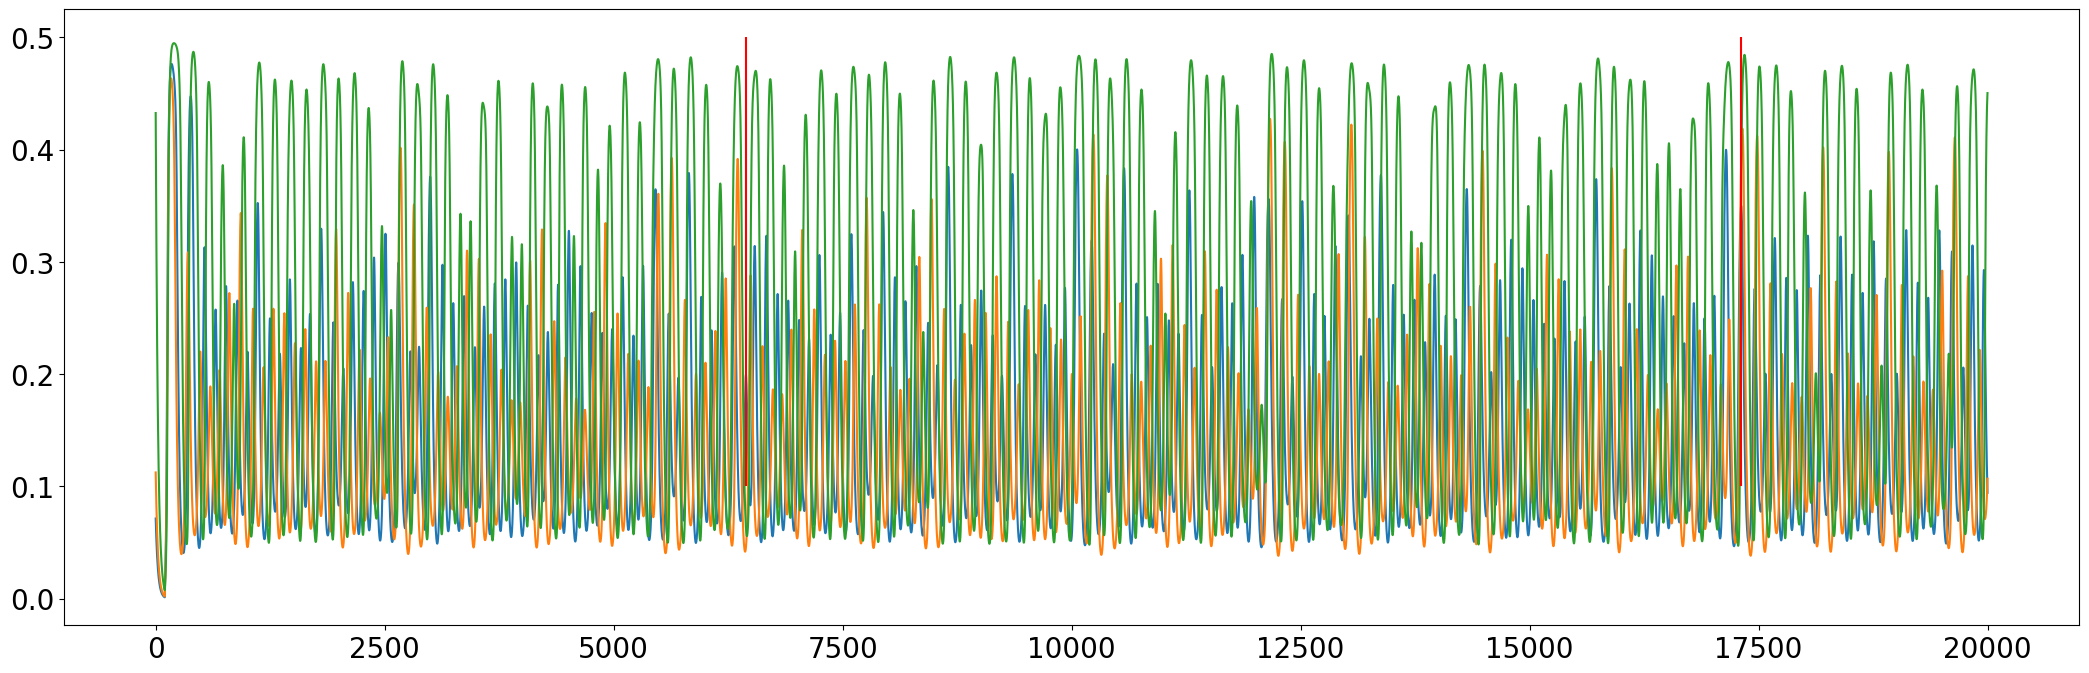

<function matplotlib.pyplot.show(close=None, block=None)>

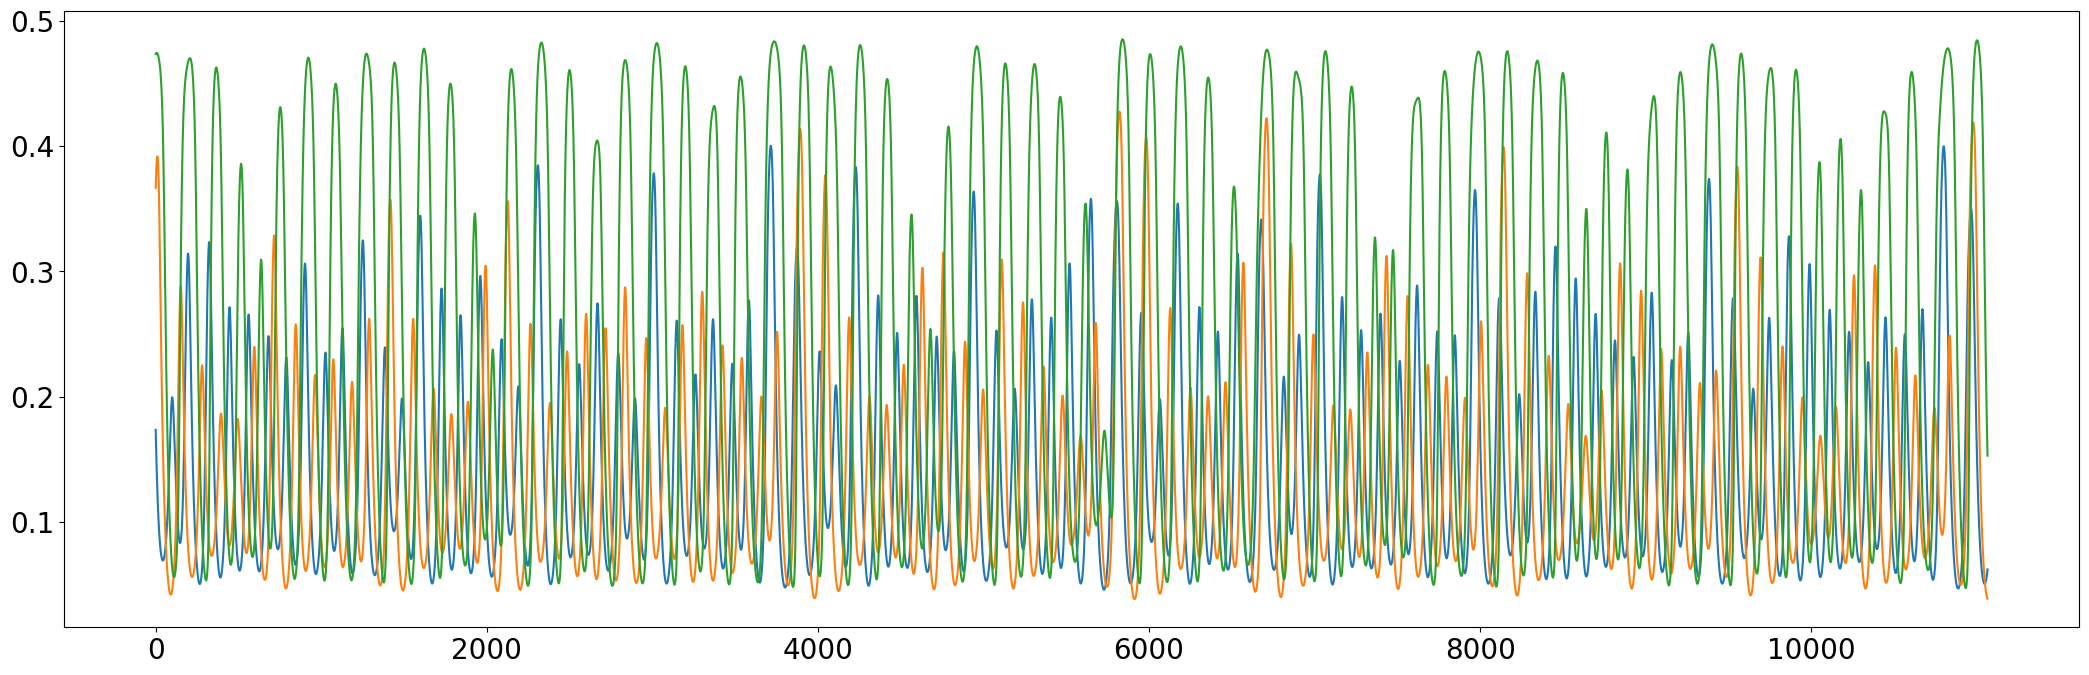

In [7]:
peaks = [scipy.signal.find_peaks(state[0,0,:])[0], scipy.signal.find_peaks(state[1,0,:])[0], scipy.signal.find_peaks(state[2,0,:])[0]]

mintotdiff = 10000
mintotdiffind = 0

maxtotdiff = 0
maxtotdiffind = 0

print(peaks[0])

for p in peaks[0][5:-5]:
    diff1 = np.abs(p - peaks[1])
    diff2 = np.abs(p - peaks[2])

    mindiff = min(diff1) + min(diff2)

    if mindiff < mintotdiff:
        mintotdiff = mindiff
        mintotdiffind = p

    if mindiff > maxtotdiff:
        maxtotdiff = mindiff
        maxtotdiffind = p


print(mintotdiff, mintotdiffind)
print(maxtotdiff, maxtotdiffind)

fix, ax = plt.subplots(1,1, figsize=(26,8))
ax.plot(state[0,0,:])
ax.plot(state[1,0,:])
ax.plot(state[2,0,:])
ax.vlines([maxtotdiffind, mintotdiffind], 0.1, 0.5, color="red")
plt.show()

fix, ax = plt.subplots(1,1, figsize=(26,8))
ax.plot(state[0,0,min(mintotdiffind, maxtotdiffind)-100:max(mintotdiffind, maxtotdiffind)+100])
ax.plot(state[1,0,min(mintotdiffind, maxtotdiffind)-100:max(mintotdiffind, maxtotdiffind)+100])
ax.plot(state[2,0,min(mintotdiffind, maxtotdiffind)-100:max(mintotdiffind, maxtotdiffind)+100])
plt.show

In [8]:
data = dict()

data["control"] = [[None, None], [None, None], [None, None]]
data["state"] = [[None, None], [None, None], [None, None]]
data["init"] = []
data["weights"] = np.ones((3,2))
data["control_cost"] = np.zeros((3,2))
data["sync_cost"] = np.zeros((3,2))

einit = np.zeros((N, 1))
iinit = np.zeros((N, 1))

for n in range(N):
    einit[n,:] = state[n,0,mintotdiffind-1000]
    iinit[n,:] = state[n,1,mintotdiffind-1000]

data["init"].append([einit, iinit])

einit = np.zeros((N, 1))
iinit = np.zeros((N, 1))

for n in range(N):
    einit[n,:] = state[n,0,maxtotdiffind-1000]
    iinit[n,:] = state[n,1,maxtotdiffind-1000]

data["init"].append([einit, iinit])

In [9]:
weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [10]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 800
control_interval = [1000, -2000]
cost_interval = [1000, -2000]

maxstr = 5
pr = np.arange(0,501,10)

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [11]:
uncontrolled_state = [None, None]
uncontrolled_cost = np.zeros((3, 2))

In [15]:
print(data["weights"])

[[1.e-05 1.e-04]
 [1.e+00 1.e+00]
 [1.e-02 1.e-02]]


---------------------------------------  F
---------------------------------------  CC
---------------------------------------  VAR
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 527.2427064482148
Final cost : 527.2427064482148
Compute control for a deterministic system
Cost in iteration 0: 459.0689192993835
Final cost : 459.0689192993835
Compute control for a deterministic system
Cost in iteration 0: 459.0689192993835
Converged in iteration 1 with cost 459.0689192993835
Final cost : 459.0689192993835
Compute control for a deterministic system
Cost in iteration 0: 459.0689192993835
Converged in iteration 1 with cost 459.0689192993835
Final cost : 459.0689192993835
Compute control for a deterministic system
Cost in iteration 0: 459.0689192993835
Converged in iteration 1 with cost 459.0689192993835
Final cost : 459.0689192993835
Compute control for a deterministic system
Cost in iteration 0: 459.0689192993835
Converged in it

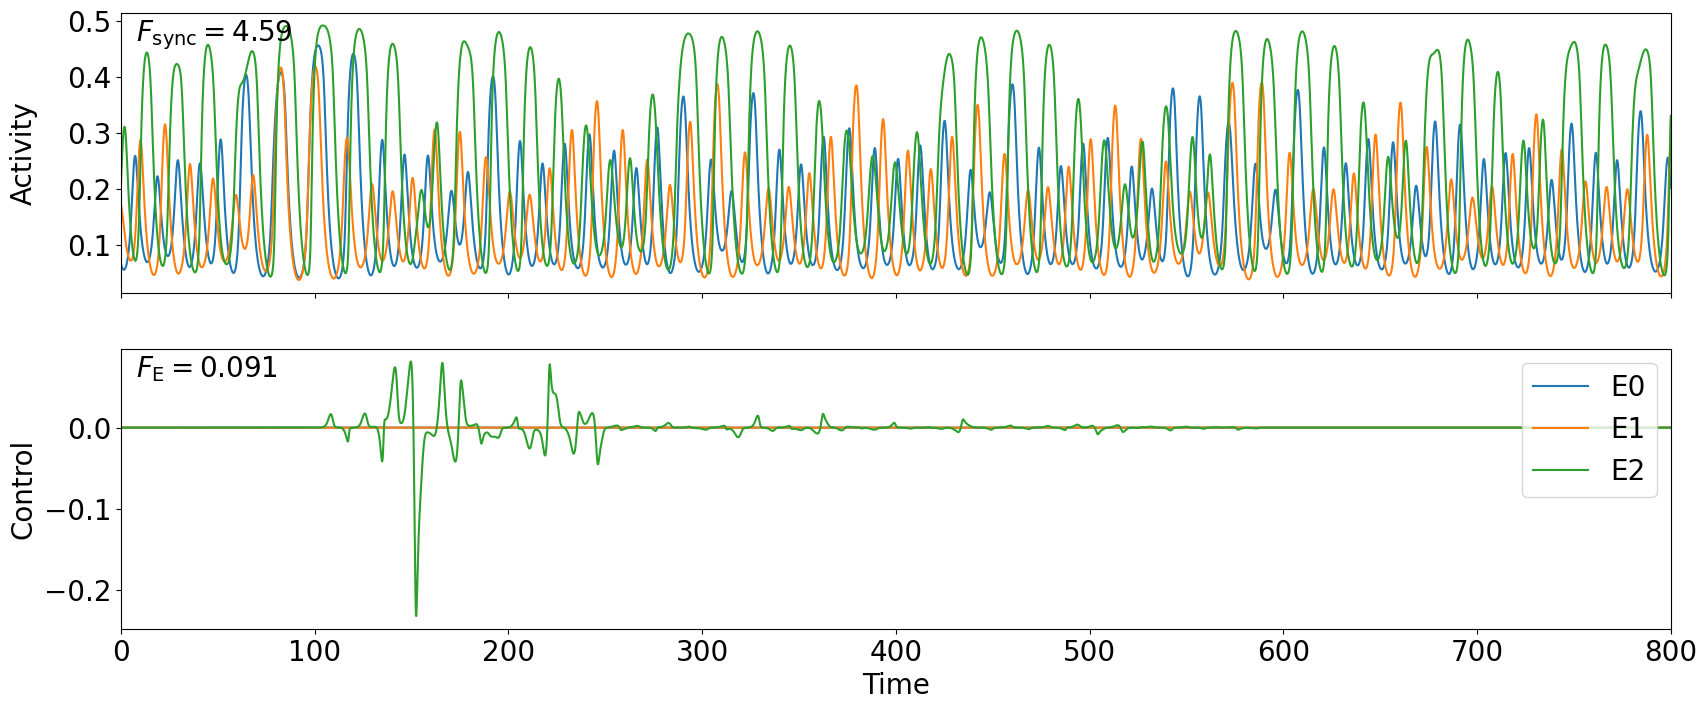

In [60]:
it = 3

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling_array[0]
dt = 0.1
model.params.dt = dt

model.params['duration'] = duration
model.params.exc_ext_baseline = eext[0]
model.params.inh_ext_baseline = iext[0]

model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

for init_ind in range(2):

    if init_ind not in [0]: continue

    model.params["exc_init"] = data["init"][init_ind][0]
    model.params["inh_init"] = data["init"][init_ind][1]

    model.run()

    uncontrolled_state[init_ind] = [model.exc, model.inh]

    for mi, method in enumerate(["F", "CC", "VAR"]):

        print("--------------------------------------- ", method)

        if mi not in [2]: continue

        data["weights"][mi, init_ind] = 1e-2

        #for factor in np.random.random(1):
        for factor in [1]:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                        cost_matrix=costmat, control_matrix=controlmat)
            
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = 1.
            if method == "F":
                model_controlled.weights["w_f_sync"] = 1./data["weights"][mi, init_ind] 
            elif method == "CC":
                model_controlled.weights["w_cc"] = 1./data["weights"][mi, init_ind] 
            elif method == "VAR":
                model_controlled.weights["w_var"] = 1./data["weights"][mi, init_ind]

            model_controlled.maximum_control_strength = maxstr

            model_controlled.optimize(0)
            uncontrolled_cost[mi, init_ind] = model_controlled.cost_history[-1]*data["weights"][mi, init_ind]

            if True:
                if type(data["control"][mi][init_ind]) != type(None):
                    model_controlled.control = data["control"][mi][init_ind].copy()
                    model_controlled.update_input()

            model_controlled.optimize(0)

            for j in range(1):
                model_controlled.grad_method = 0
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-6., 2., 1.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-7., 5., 1.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(10)

            print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

            data["control"][mi][init_ind] = model_controlled.control.copy()
            data["state"][mi][init_ind] = model_controlled.get_xs()

        if False:
            mod = copy.deepcopy(model_controlled.model)
            mod.params.duration = 2000.
            input = np.zeros((N,2,1+int(mod.params.duration/dt)))
            input[:,:,:1+int(duration/dt)] = model_controlled.control.copy()
            mod.params.exc_ext = input[:,0,:]
            mod.run()

            plot_c = input.copy()
            plot_s = np.concatenate( (mod.exc[:,np.newaxis,:], mod.inh[:,np.newaxis,:]), axis=1 )

        coc = cost_functions.control_strength_cost(data["control"][mi][init_ind], weights, dt)
        data["control_cost"][mi, init_ind] = coc
        data["sync_cost"][mi, init_ind] = (model_controlled.cost_history[-1] - coc)*data["weights"][mi, init_ind]

        print("cost of control = ", coc)
        print("cost sync = ", data["sync_cost"][mi, init_ind])
        plot_control(data["control"][mi][init_ind], data["state"][mi][init_ind], duration, dt, coc, data["sync_cost"][mi, init_ind])
        #plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt)

        with open(os.path.join(pickledir, 'beat_osc_3n.pickle'), 'wb') as f:
            pickle.dump(data, f)

In [ ]:
Final cost : 445.16763355554497
gradient =  14172762.511187406
cost of control =  0.00014647140678283627
cost sync =  4.451674870841382

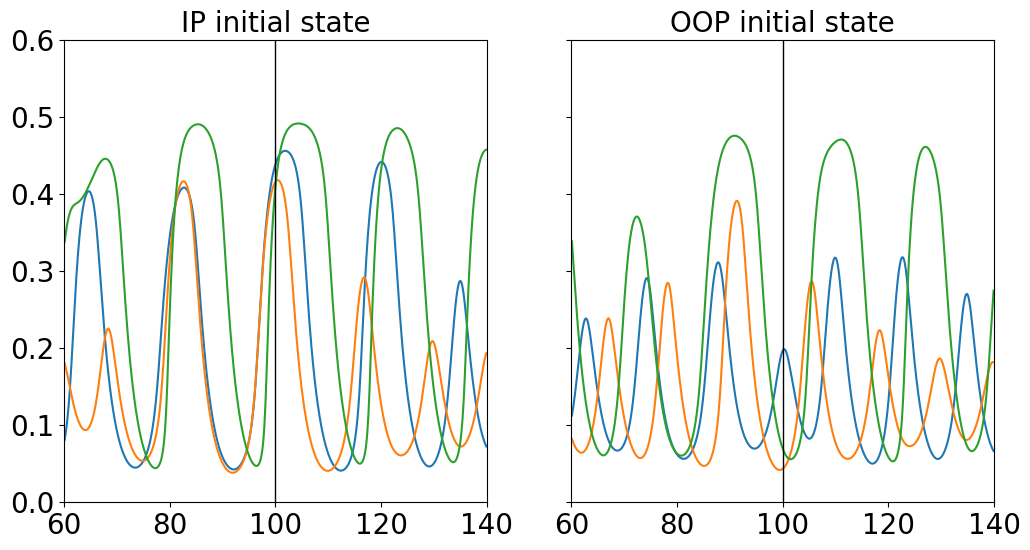

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

time = np.arange(0, duration+dt, dt)
indmax = 1400
indmin = 600

for n in range(N):
    ax[0].plot(time[1+indmin:indmax], uncontrolled_state[0][0][n,indmin:indmax-1])
    ax[1].plot(time[1+indmin:indmax], uncontrolled_state[1][0][n,indmin:indmax-1])

ax[0].vlines([100], 0, 0.6, color="black", linewidth=1)
ax[1].vlines([100], 0, 0.6, color="black", linewidth=1)

ax[0].set_ylim(0, 0.6)
ax[0].set_xlim(int(indmin*dt), int(indmax*dt))

ax[0].set_title("IP initial state")
ax[1].set_title("OOP initial state")

plt.savefig(os.path.join(dir, "chaos_init_states.pdf"), bbox_inches='tight')
plt.show()

In [57]:
data["sync_cost"]

array([[-5.06788156e-04, -5.92563227e-04],
       [-1.33910083e+02, -1.19582338e+02],
       [ 4.55099130e+02,  4.66076499e+02]])

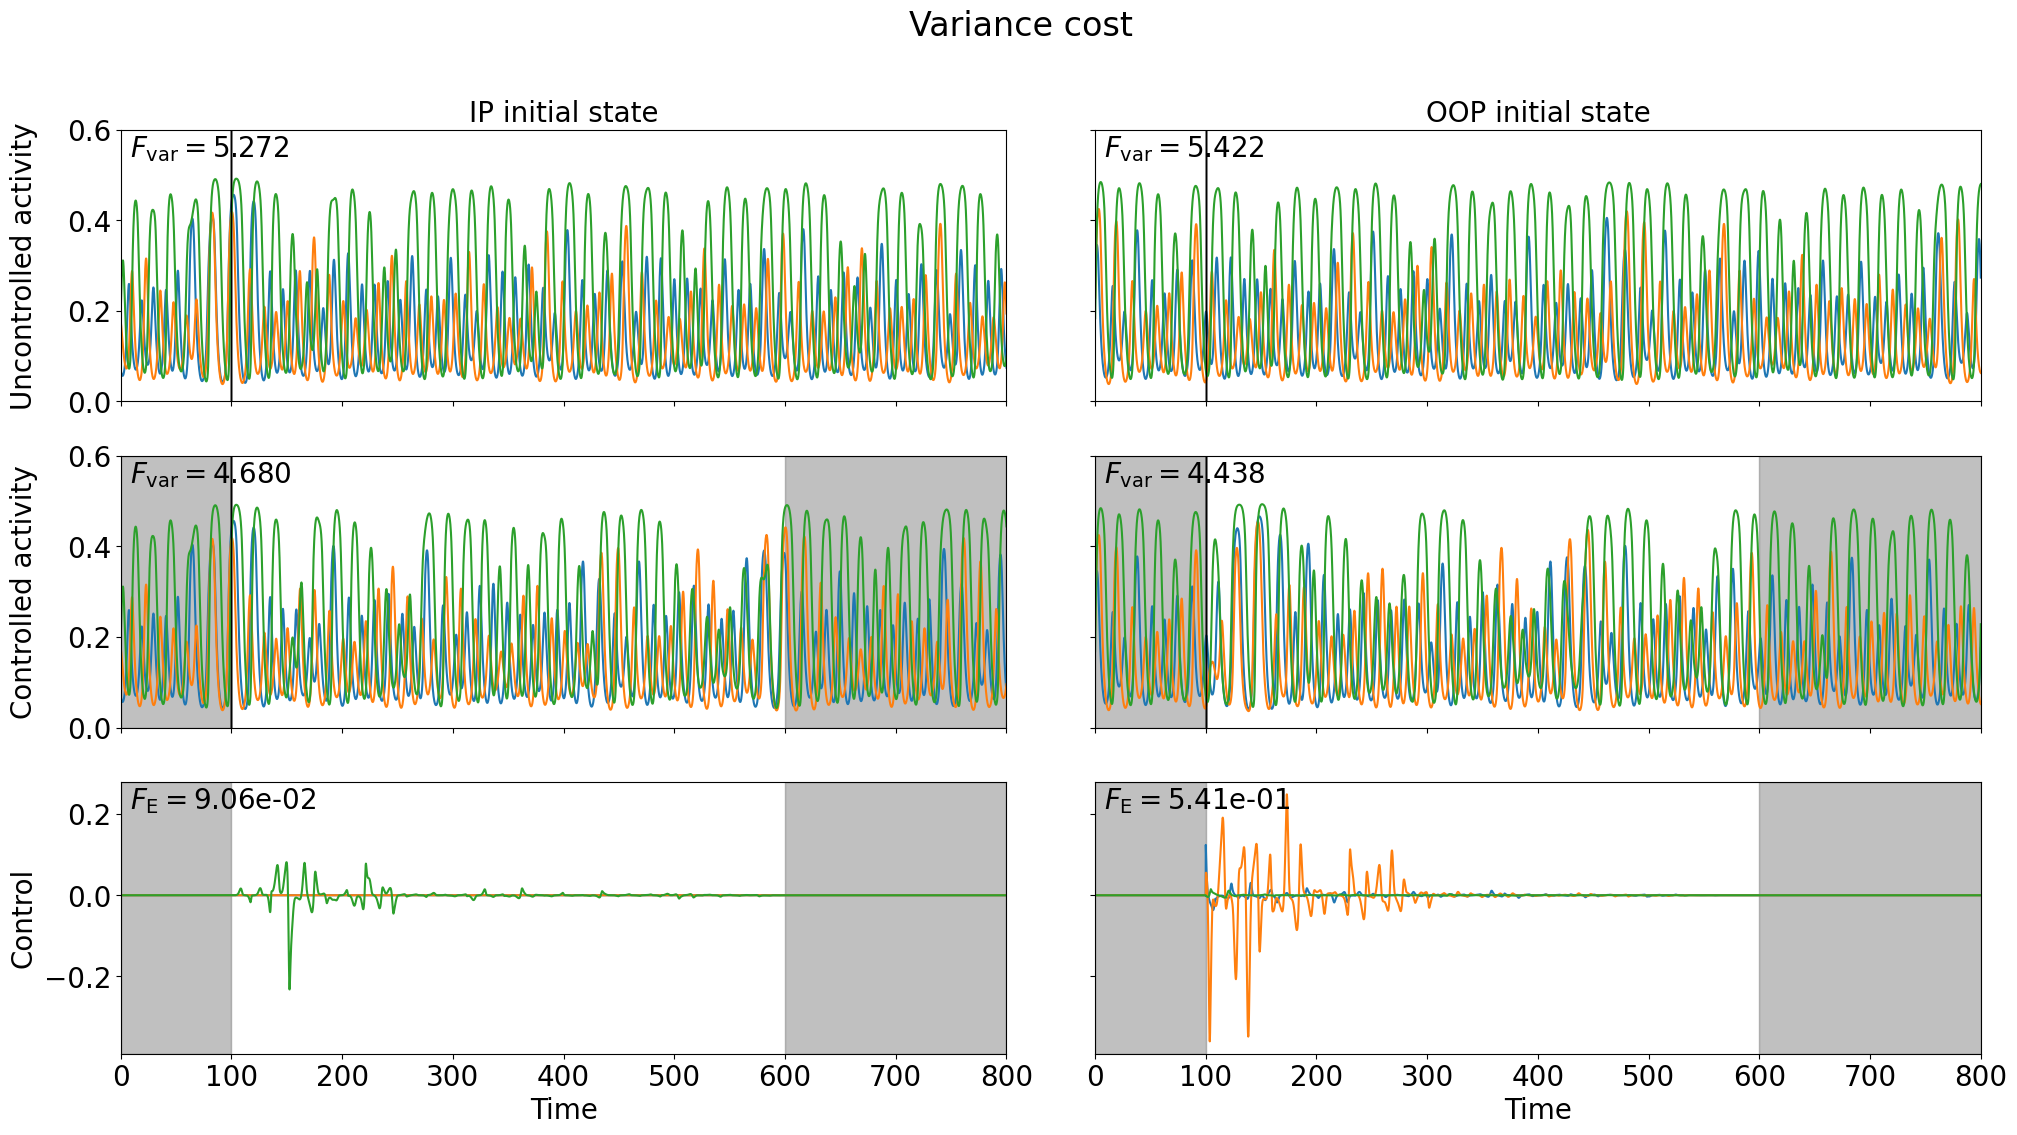

In [115]:
mi = 2

fig, ax = plt.subplots(3, 2, figsize=(24,12), sharex=True, sharey="row")

time = np.arange(0, duration+dt, dt)

for n in range(N):
    ax[0,0].plot(time[1:], uncontrolled_state[0][0][n,:])
    ax[0,1].plot(time[1:], uncontrolled_state[1][0][n,:])
    ax[1,0].plot(time, data["state"][mi][0][n,0,:])
    ax[1,1].plot(time, data["state"][mi][1][n,0,:])
    ax[2,0].plot(time, data["control"][mi][0][n,0,:])
    ax[2,1].plot(time, data["control"][mi][1][n,0,:])

    for k in [1,2]:
        ax[k,0].axvspan(0, 100, color="grey", alpha=0.2)
        ax[k,0].axvspan(600, 800, color="grey", alpha=0.2)
        ax[k,1].axvspan(0, 100, color="grey", alpha=0.2)
        ax[k,1].axvspan(600, 800, color="grey", alpha=0.2)

    ax[0,0].vlines([100], 0, 0.6, color="black", linewidth=1)
    ax[0,1].vlines([100], 0, 0.6, color="black", linewidth=1)

    ax[1,0].vlines([100], 0, 0.6, color="black", linewidth=1)
    ax[1,1].vlines([100], 0, 0.6, color="black", linewidth=1)

ax[0,0].set_title("IP initial state")
ax[0,1].set_title("OOP initial state")

xpos = 0.01
ypos = 0.9

if mi == 0:
    ax[0,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:.2g}".format(uncontrolled_cost[mi,0]), transform=ax[0,0].transAxes)
    ax[0,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:.2g}".format(uncontrolled_cost[mi,1]), transform=ax[0,1].transAxes)
    ax[1,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data["sync_cost"][mi,0]), transform=ax[1,0].transAxes)
    ax[1,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data["sync_cost"][mi,1]), transform=ax[1,1].transAxes)
elif mi == 1:
    ax[0,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:.3f}".format(uncontrolled_cost[mi,0]), transform=ax[0,0].transAxes)
    ax[0,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:.3f}".format(uncontrolled_cost[mi,1]), transform=ax[0,1].transAxes)
    ax[1,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.2f}".format(data["sync_cost"][mi,0]), transform=ax[1,0].transAxes)
    ax[1,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.2f}".format(data["sync_cost"][mi,1]), transform=ax[1,1].transAxes)
elif mi == 2:
    ax[0,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:.3f}".format(uncontrolled_cost[mi,0]), transform=ax[0,0].transAxes)
    ax[0,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:.3f}".format(uncontrolled_cost[mi,1]), transform=ax[0,1].transAxes)
    ax[1,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.3f}".format(data["sync_cost"][mi,0]), transform=ax[1,0].transAxes)
    ax[1,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.3f}".format(data["sync_cost"][mi,1]), transform=ax[1,1].transAxes)



if mi != 2:
    ax[2,0].text(xpos, ypos, r"$F_\text{E} = $" + "{0:.2f}".format(data["control_cost"][mi,0]), transform=ax[2,0].transAxes)
    ax[2,1].text(xpos, ypos, r"$F_\text{E} = $" + "{0:.2f}".format(data["control_cost"][mi,1]), transform=ax[2,1].transAxes)
else:
    ax[2,0].text(xpos, ypos, r"$F_\text{E} = $" + "{0:.2e}".format(data["control_cost"][mi,0]), transform=ax[2,0].transAxes)
    ax[2,1].text(xpos, ypos, r"$F_\text{E} = $" + "{0:.2e}".format(data["control_cost"][mi,1]), transform=ax[2,1].transAxes)


ax[0,0].set_ylim(0,0.6)
ax[1,0].set_ylim(0,0.6)

ax[0,0].set_xlim(0,duration)
ax[2,0].set_xlabel("Time")
ax[2,1].set_xlabel("Time")

ax[0,0].set_ylabel("Uncontrolled activity")
ax[1,0].set_ylabel("Controlled activity")
ax[2,0].set_ylabel("Control")

fig.align_ylabels([ax[:,0]])


if mi == 0:
    fig.suptitle("Fourier cost")
elif mi == 1:
    fig.suptitle("Cross-correlation cost")
elif mi == 2:
    fig.suptitle("Variance cost")

plt.subplots_adjust(wspace=0.1, 
                    hspace=0.2)

plt.savefig(os.path.join(dir, "chaos_" + str(mi) + ".pdf"), bbox_inches='tight')
plt.show()

In [49]:
def plot_control(c, s, dur, dt, coc, cos):
    if dur < 1000:
        y1lim = [1.1 * np.amin(c[:,:,1:]), 1.1 * np.amax(c[:,:,1:])]
        fig, ax = plt.subplots(2,1, figsize=(20,8), sharex=True)
    else:
        y1lim = [1.1 * np.amin(c), 1.1 * np.amax(c)]
        fig, ax = plt.subplots(2,1, figsize=(28,8))

    time_array = np.arange(0, dur+dt, dt)

    for n in range(N):
        ax[0].plot(time_array,s[n,0,:], label="E{}".format(n))
        ax[1].plot(time_array, c[n,0,:], label="E{}".format(n))

    #ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")

    ax[0].set_xlim(0, dur)
    ax[1].set_xlim(0, dur)
    #ax[0].set_ylim(y0lim)
    #ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    xpos = 0.01
    ypos = 0.9

    ax[1].text(xpos, ypos, r"$F_\text{E} = $" + "{0:.2g}".format(coc), transform=ax[1].transAxes)
    ax[0].text(xpos, ypos, r"$F_\text{sync} = $" + "{0:.2f}".format(cos), transform=ax[0].transAxes)
    
    fig.align_ylabels([ax[:]])


    plt.show()
    return

In [13]:
with open(os.path.join(pickledir, 'beat_osc_3n.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['control', 'state', 'init', 'weights', 'control_cost', 'sync_cost'])
